## Reading Tweets from msca-bdp-tweets bucket

### Using PySpark kernel

In [1]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [13]:
directory = 'gs://msca-bdp-tweets/final_project/'
# file = '*.json'
# path = directory + file
path = directory

In [5]:
cmd = 'hadoop fs -du -s -h ' + directory

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

156.2 G  156.2 G  gs://msca-bdp-tweets/final_project



In [ ]:
%%time

tweets_df = spark.read.json(path)

In [7]:
%%time

tweets_df.count()

CPU times: user 10.2 ms, sys: 2.39 ms, total: 12.6 ms
Wall time: 1min


25191000

### Tweet clean-up and filtering

In [15]:
tweets_filter = tweets_df.select(['id_str','in_reply_to_screen_name','retweet_count','retweeted_status','text','timestamp_ms','truncated','user'])
tweets_filter.limit(5)

id,id_str,in_reply_to_screen_name,retweet_count,retweeted_status,text,timestamp_ms,truncated,user
1449788150021333001,1449788150021333001,null,0,"[,, Sun Oct 17 14...",RT @Sandyboots202...,1634491405383,false,"[false, Thu Jan 2..."
1449788149987688454,1449788149987688454,JeffJeffry2000,0,null,@JeffJeffry2000 @...,1634491405375,true,"[false, Thu Mar 1..."
1449788150679838722,1449788150679838722,null,0,"[,, Sun Oct 17 02...",RT @K_Bishof: Me ...,1634491405540,false,"[false, Sat Dec 1..."
1449788151355121670,1449788151355121670,null,0,null,he just forgot to...,1634491405701,false,"[false, Mon Jul 1..."
1449788151581581313,1449788151581581313,null,0,"[,, Sun Oct 17 17...",RT @yvrdoran: Her...,1634491405755,false,"[false, Sat Aug 2..."


In [16]:
tweets_covid = tweets_filter.filter(tweets_filter.text.like('%covid%') | tweets_filter.retweeted_status.text.like('%covid%'))

In [10]:
tweets_covid.count()

2730097

In [17]:
save_path = 'gs://msca-bdp-students-bucket/shared_data/wanxuanzhang'

In [13]:
tweets_covid.write.format("parquet").\
mode('overwrite').\
save(save_path)

In [93]:
tweets = spark.read.parquet(save_path)
tweets.limit(5)

id_str,in_reply_to_screen_name,retweet_count,retweeted_status,text,timestamp_ms,truncated,user
1450578731060322304,null,0,null,✋✋ Get my booster...,1634679894591,false,"[false, Sat Sep 0..."
1450578729244282885,null,0,null,So lucky to move ...,1634679894158,true,"[false, Wed Dec 3..."
1450578733732032514,null,0,"[, Sat Oct 16 18:...",RT @Adamistheshii...,1634679895228,false,"[false, Wed Jul 1..."
1450578736638693380,null,0,"[, Mon Oct 18 01:...",RT @AQUARlUSMARS:...,1634679895921,false,"[false, Wed Jan 2..."
1450578737368547329,null,0,"[, Tue Oct 19 20:...",RT @annjsmall: @D...,1634679896095,false,"[false, Thu Dec 2..."


### EDA and extensive usage of available variables

In [25]:
tweets.describe()

summary,id_str,in_reply_to_screen_name,retweet_count,text,timestamp_ms
count,2730097,718651,2730097,2730097,2730097
mean,1.453720815279429...,3.1451517720571427E9,0.0,null,1.635429025846028E12
stddev,2.945222894559343E15,1.452600254647355...,0.0,null,7.021958576582956E8
min,1448850337998192642,000000001404072,0,! An extremely s...,1634267813573
max,1459021442469666820,zzzzzz_cz17,0,🪦 Due to rising ...,1636692793849


### Author identification

Identify the most prolific / influential Twitterers by message volume (original content)

In [18]:
tweets_original = tweets.\
withColumn('original', when(col('retweeted_status').isNull() & col('in_reply_to_screen_name').isNull(),1).otherwise(0))
tweets_original.limit(5)

id,id_str,in_reply_to_screen_name,retweet_count,retweeted_status,text,timestamp_ms,truncated,user,original
1454315724680437761,1454315724680437761,null,0,null,Trump knew covid ...,1635570863300,false,"[false, Fri Mar 1...",1
1454315727880601601,1454315727880601601,null,0,"[,, Thu Oct 28 22...",RT @TreJames_: If...,1635570864063,false,"[false, Tue May 2...",0
1454315728488701959,1454315728488701959,null,0,"[,, Sat Oct 30 03...",RT @strwberrymilk...,1635570864208,false,"[false, Sat Jul 2...",0
1454315730426531843,1454315730426531843,null,0,"[,, Sat Oct 30 02...",RT @apostersposte...,1635570864670,false,"[false, Thu Feb 1...",0
1454315737816895493,1454315737816895493,null,0,"[,, Fri Oct 29 21...",RT @ComicDaveSmit...,1635570866432,false,"[false, Sun Jan 0...",0


In [106]:
twitterers = tweets_original.groupby('user.id_str','user.screen_name','user.location','user.description').\
agg(sum('original').alias('num_original'),\
   count('text').alias('num_tweet')).\
orderBy('num_original',ascending=False)
twitterers.limit(10)

id_str,screen_name,location,description,num_original,num_tweet
1014560119,ClareKuehn,Toronto-Citizen o...,Retweets help mor...,445,532
1130184943,jcurlycurls,null,null,396,396
1429571873780637700,CatbearMoggy,null,Hi my name is Mog...,387,387
1199332435701485569,42Sz40,null,netstat -an -f inet,315,322
1428236322838220802,CovidHelpBot,null,For all your quic...,261,261
1326341227156033536,4elegantly,null,🛒Elegance shop ?...,257,257
2295719946,emojizedcom,"Zurich, Switzerland",null,255,259
1389125098624278528,EnewsappI,"Hyderabad, India",Welcome to https:...,217,217
1384355972181811202,COVID_metrics,null,Daily updates on ...,214,214
1178055397791293440,C3Consulting1,null,Nurturing your bu...,207,322


Identify the most prolific / influential Twitterers by message retweet (how often their messages are being retweeted)

In [108]:
twitterers_retweet = tweets.withColumn('original_twitterer_id', tweets.retweeted_status.user.id_str).\
withColumn('original_twitterer_name', tweets.retweeted_status.user.screen_name).\
filter(col('original_twitterer_id')!='NA').\
groupby('original_twitterer_id','original_twitterer_name').\
agg(count('*').alias('num_retweet')).orderBy('num_retweet', ascending=False)

twitterers_retweet.limit(10)

original_twitterer_id,original_twitterer_name,num_retweet
707231479047315456,PeterSweden7,93776
457815156,abcdrih,45440
50772918,ClayTravis,31321
1283115210107162625,8EightPillars,28519
1328132644606009344,Sasyity,21781
16949344,bmj_latest,21154
427547077,TreJames_,15638
1374317368361447434,songpinganq,14836
264361128,Liz_Wheeler,14036
318336263,drfrocester,12988


Identify influential twitterers

In [109]:
twitterers.select('num_original').describe()

summary,num_original
count,1240552
mean,0.3272680226221875
stddev,1.6127399449359052
min,0
max,445


In [111]:
twitterers_retweet.select('num_retweet').describe()

summary,num_retweet
count,87355
mean,18.378490069257627
stddev,438.27508917621356
min,1
max,93776


In [38]:
twitterers_influential = twitterers.join(twitterers_retweet, twitterers['id_str'] == twitterers_retweet['original_twitterer_id'], how = 'inner').\
drop(twitterers_retweet['original_twitterer_id']).drop(twitterers_retweet['original_twitterer_name']).\
dropDuplicates(subset = ["id_str"])

twitterers_influential.limit(5)

description,id_str,location,num_original,num_tweet,screen_name,num_retweet
“Stay focused” Be...,1005588470209933312,Area51,2,2,beelatrellll,1
du25,1012908927111987200,null,1,2,lulmoniie1,1
- daily positive ...,1017091730313744391,4 admins!,1,1,ranaltboopos,6
Conservative blog...,10198072,null,1,6,FloppingAces,1
Met Police accoun...,1022842775828684800,"London, England",1,2,MPSWestHamUtdFC,11


In [39]:
twitterers_influential = twitterers_influential.withColumn('influential', (0.99*col('num_original') + 0.01*col('num_retweet')).cast(IntegerType())).\
orderBy('influential', ascending=False)
twitterers_influential.limit(10)

description,id_str,location,num_original,num_tweet,screen_name,num_retweet,influential
I'm Peter Imanuel...,707231479047315456,"Møre og Romsdal, ...",29,39,PeterSweden7,93776,966
charge it to the ...,457815156,🇨🇩🇨🇦,1,2,abcdrih,45440,455
Retweets help mor...,1014560119,Toronto-Citizen o...,445,532,ClareKuehn,418,444
null,1130184943,null,396,396,jcurlycurls,6,392
http://Outkick.co...,50772918,Nashville,37,46,ClayTravis,31321,349
netstat -an -f inet,1199332435701485569,null,315,322,42Sz40,43,312
the professional.,1283115210107162625,null,1,2,8EightPillars,28519,286
For all your quic...,1428236322838220802,null,261,261,CovidHelpBot,1,258
The BMJ is patien...,16949344,London Beijing De...,46,53,bmj_latest,21154,257
null,2295719946,"Zurich, Switzerland",255,259,emojizedcom,270,255


Who are these Twitterers

In [41]:
twitterers_organization = twitterers_influential.\
withColumn('organization', \
           when(twitterers.description.like('%government%'),'government entities').\
           when(twitterers.description.like('%health%'),'health organizations').\
           when(twitterers.description.like('%news%'),'news outlets').\
           when(twitterers.description.like('%influencer%'),'social media influencers').\
           when(twitterers.description.like('%media%'),'social media influencers').\
           otherwise('others'))
twitterers_organization.limit(5)

description,id_str,location,num_original,num_tweet,screen_name,num_retweet,influential,organization
I'm Peter Imanuel...,707231479047315456,"Møre og Romsdal, ...",29,39,PeterSweden7,93776,966,others
charge it to the ...,457815156,🇨🇩🇨🇦,1,2,abcdrih,45440,455,others
Retweets help mor...,1014560119,Toronto-Citizen o...,445,532,ClareKuehn,418,444,others
null,1130184943,null,396,396,jcurlycurls,6,392,others
http://Outkick.co...,50772918,Nashville,37,46,ClayTravis,31321,349,others


In [43]:
twitterers_organization.groupby('organization').\
agg(count('*').alias('organization_count')).show()

+--------------------+------------------+
|        organization|organization_count|
+--------------------+------------------+
|social media infl...|               747|
|              others|             77894|
|health organizations|              1300|
| government entities|               411|
|        news outlets|              1167|
+--------------------+------------------+



Visualize the distribution of tweet volume by Twitterers and types of organizations

In [8]:
twitterers_organization_dist = twitterers_organization.groupby('organization').\
agg(sum('num_tweet').alias('num_tweet_by_organization')).toPandas()

twitterers_organization_dist

,organization,num_tweet_by_organization
0,social media influencers,3409
1,others,432519
2,health organizations,8358
3,government entities,4000
4,news outlets,5946


In [3]:
import matplotlib.pyplot as plt

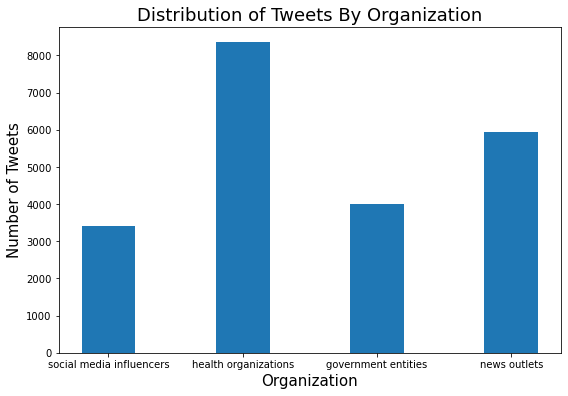

In [21]:
twitterers_organization_dist_plot = twitterers_organization_dist.drop(index=[1])

plt.figure(figsize=(9,6))
plt.bar(twitterers_organization_dist_plot.organization, twitterers_organization_dist_plot.num_tweet_by_organization, width=0.4)
plt.xlabel('Organization', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.title('Distribution of Tweets By Organization', fontsize=18)
plt.savefig('./tweet_dist_organization.jpg')
plt.show()

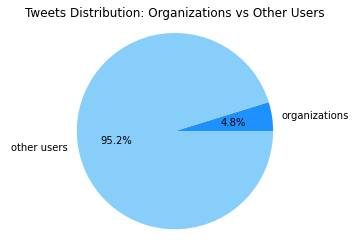

In [13]:
import pandas as pd
labels = ['organizations', 'other users']
sizes = [21713, 432519]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors = ['dodgerblue','lightskyblue'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tweets Distribution: Organizations vs Other Users')
plt.savefig('./tweet_dist_organization_pie.jpg')
plt.show()

### Location analysis

Where are these Twitterers located

In [26]:
twitterers_location = twitterers.filter(col('location') != 'NA').groupby('location').\
agg(count('*').alias('num_twitterers')).orderBy('num_twitterers',ascending=False)

twitterers_location.limit(5)

location,num_twitterers
United States,12750
"London, England",6613
United Kingdom,5052
she/her,4712
USA,4605


In [28]:
twitterers_location_df = twitterers_location.toPandas()

In [29]:
twitterers_location_df.to_csv('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/twitterers_location/twitterers_location_df.csv')

Visualize the geographical distribution

In [25]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
twitterers_location_df_cleaned = pd.read_csv('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/twitterers_location/twitterers_location_df_cleaned.csv')

In [54]:
world_df = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
world_df = world_df[world_df["continent"] != "Antarctica"]

In [55]:
data_geod = gp.GeoDataFrame(twitterers_location_df_cleaned)
world_df = world_df.rename(index = str, columns = {'name':'location'})
da_merge = world_df.merge(data_geod, on = 'location', how = 'left')
da_merge['num_twitterers'][np.isnan(da_merge['num_twitterers'])] = 0

<ipython-input-55-6043a6c0a32d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_merge['num_twitterers'][np.isnan(da_merge['num_twitterers'])] = 0


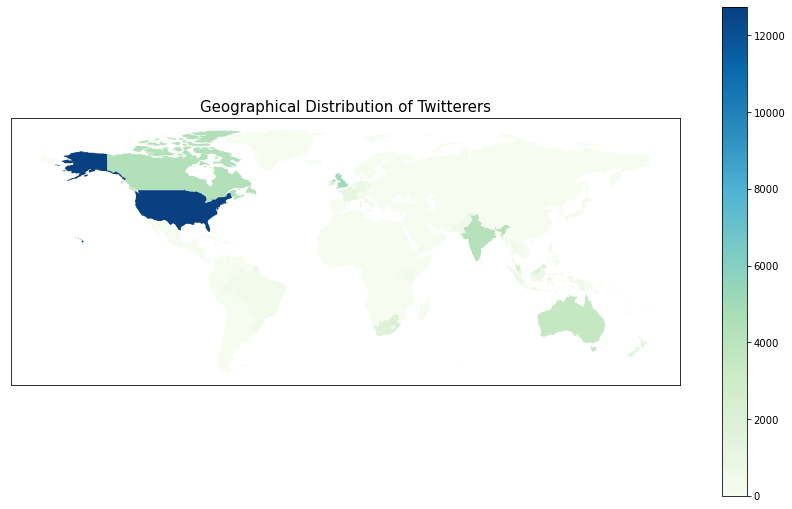

In [81]:
da_merge.plot('num_twitterers', cmap = 'GnBu', alpha = 1, figsize = (15, 9), legend = True)
plt.title('Geographical Distribution of Twitterers', fontsize=15)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('./twitterers_location.jpg')

### Timeline analysis

In [77]:
import time
import pyspark

In [35]:
tweets_time = tweets.withColumn('timestamp', col('timestamp_ms')/1000.0).\
withColumn('time', from_unixtime('timestamp').cast(DateType()))

In [37]:
tweets_time = tweets_time.withColumn('month', month('time')).\
withColumn('date', dayofmonth('time'))
tweets_time.limit(5)

id_str,in_reply_to_screen_name,retweet_count,retweeted_status,text,timestamp_ms,truncated,user,timestamp,time,month,date
1456744395189932034,magapolitics2,0,null,@magapolitics2 Th...,1636149903472,false,"[false, Fri Oct 0...",1.636149903472E9,2021-11-05,11,5
1456744398138626049,null,0,"[, Fri Nov 05 00:...",RT @elisaperego78...,1636149904175,false,"[false, Fri Nov 1...",1.636149904175E9,2021-11-05,11,5
1456744399178764289,null,0,null,On this day in 20...,1636149904423,true,"[false, Sat Jul 0...",1.636149904423E9,2021-11-05,11,5
1456744401007415296,MySportsUpdate,0,null,@MySportsUpdate L...,1636149904859,false,"[false, Tue Aug 1...",1.636149904859E9,2021-11-05,11,5
1456744404090298373,null,0,null,Although much of ...,1636149905594,false,"[false, Sat May 1...",1.636149905594E9,2021-11-05,11,5


In [42]:
tweets_time_dist = tweets_time.groupby('time','month','date').agg(count('*').alias('num_tweet')).orderBy('month','date')
tweets_time_dist.limit(5)

time,month,date,num_tweet
2021-10-15,10,15,107627
2021-10-16,10,16,99282
2021-10-17,10,17,92527
2021-10-18,10,18,122846
2021-10-19,10,19,114737


In [44]:
tweets_time_dist.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/tweets_time_dist')

In [85]:
tweets_time_dist = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/tweets_time_dist').orderBy('month','date')

In [86]:
tweets_time_dist_df = tweets_time_dist.toPandas()

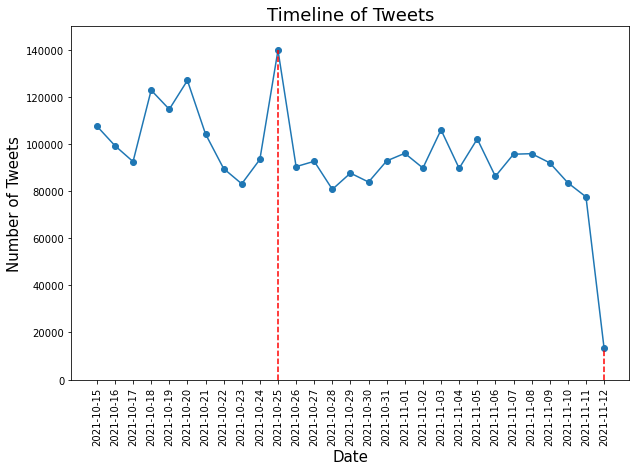

In [87]:
import matplotlib.pyplot as plt


x = tweets_time_dist_df.time
y = tweets_time_dist_df.num_tweet
plt.figure(figsize=(10,6.5))
plt.plot(range(len(x)), y, marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.title('Timeline of Tweets', fontsize=18)
plt.xticks(range(len(x)), x, rotation='vertical')
plt.ylim(0, 150000)
plt.plot([10, 10],[0, tweets_time_dist_df['num_tweet'][10]], color='red', linestyle='--')
plt.plot([28, 28],[0, tweets_time_dist_df['num_tweet'][28]], color='red', linestyle='--')
plt.savefig('./timeline.jpg')
plt.show()

### Message uniqueness analysis

LSH

In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [38]:
tweets_text= tweets_original.filter(col('original') == 1).\
join(twitterers_organization, tweets_original.user.id_str == twitterers_organization.id_str, how='inner').\
    select([tweets_original.id, tweets_original.text, twitterers_organization.organization])
tweets_text.limit(5)

id,text,organization
1456455012054454276,#OSHA released it...,others
1456455034619768843,I had covid carin...,health organizations
1456455071626113037,The latest The KA...,others
1458444272764547077,Makes a good poin...,others
1458444310270169090,One more week lik...,others


In [39]:
tokens = tweets_text.filter(col('text') != 'NA').\
    withColumn('list_of_words', lower(trim(tweets_text['text'])))
tokens = tokens.withColumn('list_of_words', split(tokens['list_of_words'], " "))

word_udf = udf(lambda arr: [x for x in arr if len(x) > 1], ArrayType(StringType()))
tokens = tokens.withColumn('list_of_words', word_udf(col('list_of_words')))

In [40]:
tokens.limit(5)

id,text,organization,list_of_words
1456321864947666945,Big East announce...,others,"[big, east, annou..."
1456321892680355847,I love this chart...,news outlets,"[love, this, char..."
1456321907121430539,I’m not a hater a...,others,"[i’m, not, hater,..."
1456321911781220354,4 children’s deat...,others,"[children’s, deat..."
1456321943204859913,Was anyone in Sas...,others,"[was, anyone, in,..."


In [48]:
#Drop records with no tokens
tokens = tokens.where(col('list_of_words').getItem(0).isNotNull())
tokens.limit(5).toPandas()

,id,text,organization,list_of_words
0,1452378602687827975,The latest The Biotech Forum! https://t.co/L2g...,others,"[the, latest, the, biotech, forum!, https://t...."
1,1452378639157313538,In the beginning I assumed that covid might ex...,others,"[in, the, beginning, assumed, that, covid, mig..."
2,1452378669075337217,Seeing so many girls getting spiked atm it’s f...,others,"[seeing, so, many, girls, getting, spiked, atm..."
3,1452378763203915777,Let covid rip is no different to let homelessn...,others,"[let, covid, rip, is, no, different, to, let, ..."
4,1452378794266927109,Covid passports dont stop spread of covid. Its...,government entities,"[covid, passports, dont, stop, spread, of, cov..."


government entities

In [25]:
df_tokens = tokens.filter(col('organization') == 'government entities')

In [26]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [27]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [54]:
df_hashed.limit(5)

id,text,organization,list_of_words,features,hashes
1453908248130560000,These charts for ...,government entities,"[these, charts, f...","(5837,[0,4,7,8,17...","[[4.7945584E7], [..."
1454896794031296519,Proven effective ...,government entities,"[proven, effectiv...","(5837,[1,4,7,15,1...","[[3040515.0], [4...."
1449847362873143300,Talking to an old...,government entities,"[talking, to, an,...","(5837,[0,2,8,9,10...","[[4.7945584E7], [..."
1452370097478197260,Desperation. Ut...,government entities,"[desperation., ...","(5837,[0,2,15,64,...","[[4.7945584E7], [..."
1454145126998044672,Rich countries ke...,government entities,"[rich, countries,...","(5837,[1,2,7,35,4...","[[1.04460723E8], ..."


In [28]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [63]:
df_dups_text.limit(5)

distCol,id_A,id_B,text_A,text_B
0.30000000000000004,1457702761454243845,1457703189952794630,3% of the world p...,3% of the world p...
0.5416666666666667,1450831798909513736,1451504496392147008,"""If""?? Please he...",Please help us fa...
0.1875,1450835499887874054,1458095827642159106,The latest Real E...,The latest Real E...
0.4,1458095827642159106,1458466185574551557,The latest Real E...,The latest Real E...
0.4375,1451199848800088077,1458836712080166916,The latest Real E...,The latest Real E...


In [29]:
records = df_hashed.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1033
Duplicate titles based on { 0.7 } jaccard distance:  104
Unique titles based on { 0.7 } jaccard distance:  0.7 :  929


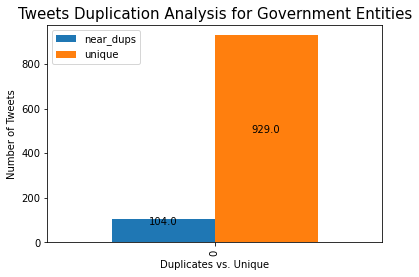

In [30]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique",\
    ylabel='Number of Tweets')
ax.set_title('Tweets Duplication Analysis for Government Entities', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
        
ax.figure.savefig('./dups_government_entities.jpg')

health organizations

In [19]:
df_tokens = tokens.filter(col('organization') == 'health organizations')

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [21]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [22]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [23]:
records = df_hashed.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3412
Duplicate titles based on { 0.7 } jaccard distance:  984
Unique titles based on { 0.7 } jaccard distance:  0.7 :  2428


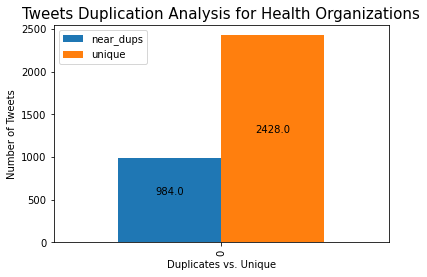

In [24]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique",\
    ylabel='Number of Tweets')
ax.set_title('Tweets Duplication Analysis for Health Organizations', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
        
ax.figure.savefig('./dups_health_organizations.jpg')

news outlets

In [13]:
df_tokens = tokens.filter(col('organization') == 'news outlets')

In [14]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [15]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [16]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [17]:
records = df_hashed.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based ohn {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3726
Duplicate titles based on { 0.7 } jaccard distance:  1049
Unique titles based on { 0.7 } jaccard distance:  0.7 :  2677


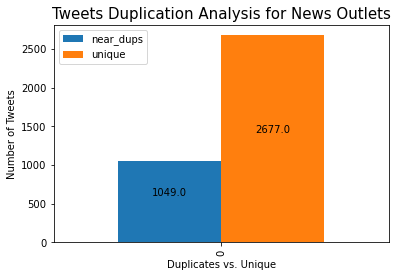

In [18]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique",\
    ylabel='Number of Tweets')
ax.set_title('Tweets Duplication Analysis for News Outlets', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
        
ax.figure.savefig('./dups_news_outlets.jpg')

social media influencers

In [31]:
df_tokens = tokens.filter(col('organization') == 'social media influencers')

In [32]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [33]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [34]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [35]:
records = df_hashed.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1343
Duplicate titles based on { 0.7 } jaccard distance:  100
Unique titles based on { 0.7 } jaccard distance:  0.7 :  1243


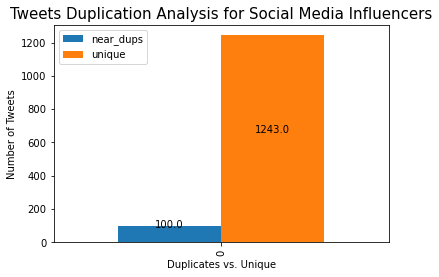

In [36]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique",\
    ylabel='Number of Tweets')
ax.set_title('Tweets Duplication Analysis for Social Media Influencers', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
        
ax.figure.savefig('./dups_social_media_influencers.jpg')

In [ ]:
tokens.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/tokens')

In [2]:
twitterers_organization = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/wanxuanzhang/twitterers_organization')